---
## ⚠️ Not: Bu eğitim loop’undan elde edilen metrics değerlerini ciddiye almayınız. Amaç yalnızca eğitim sürecinin işleyişini ve hesaplanan metriklerin kullanımını göstermektir. Gerçekçi performans değerlendirmeleri için, daha kapsamlı veri setleri ve optimize edilmiş model konfigürasyonları ile diğer LLM projelerine göz atmanız tavsiye edilir.
---

In [1]:
from torch.utils.data import DataLoader , Dataset
from transformers import AutoTokenizer, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
import math
from nltk.translate.bleu_score import corpus_bleu

c:\Users\hdgn5\.conda\envs\torch_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Tokenizasyon


In [2]:
class TokenizasyonDataset(Dataset):
    def __init__(self, sources, targets, tokenizer_name="t5-small", max_length=64):
        super().__init__()
        self.sources = sources
        self.targets = targets
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length

        # Pad token yoksa düzelt
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        # Decoder başlangıç tokeni belirle
        self.decoder_start_token_id = (
            self.tokenizer.bos_token_id if self.tokenizer.bos_token_id is not None
            else self.tokenizer.pad_token_id
        )

    def __len__(self):
        return len(self.sources)

    def __getitem__(self, idx):
        # Encoder tarafı
        enc = self.tokenizer(
            self.sources[idx],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Decoder tarafı
        dec = self.tokenizer(
            self.targets[idx],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Decoder input ve target oluştur
        decoder_input_ids = torch.cat(
            [torch.full((1, 1), self.decoder_start_token_id), dec['input_ids'][:, :-1]],
            dim=1
        )
        decoder_target_ids = dec['input_ids']

        return {
            'encoder_input_ids': enc['input_ids'].squeeze(0),
            'encoder_attention_mask': enc['attention_mask'].squeeze(0),
            'decoder_input_ids': decoder_input_ids.squeeze(0),
            'decoder_attention_mask': dec['attention_mask'].squeeze(0),
            'decoder_target_ids': decoder_target_ids.squeeze(0)
        }


### GET_İTEM Ne yapıyor ? 

#### 🧠 Yani:

* idx → o sıradaki örnek (örneğin 0. cümle, 1. cümle vs.)

* Fonksiyonun görevi → o tek örneği modelin anlayacağı tensörlere dönüştürmek

* DataLoader → bunu her örnek için çağırır ve collate_fn ile batch haline getirir

#### 🎯 Kısa Özet:

* __getitem__() bir veri kümesindeki **tek örneği alır, işler, ve modelin doğrudan kullanabileceği tensorleri döndürür.`

In [3]:
def collate_fn(batch):
    enc_ids = torch.stack([item['encoder_input_ids'] for item in batch])
    enc_mask = torch.stack([item['encoder_attention_mask'] for item in batch])
    dec_ids = torch.stack([item['decoder_input_ids'] for item in batch])
    dec_mask = torch.stack([item['decoder_attention_mask'] for item in batch])
    dec_target = torch.stack([item['decoder_target_ids'] for item in batch])
    return {
        'encoder_input_ids': enc_ids,
        'encoder_attention_mask': enc_mask,
        'decoder_input_ids': dec_ids,
        'decoder_attention_mask': dec_mask,
        'decoder_target_ids': dec_target
    }

In [4]:
input_texts = [
    "Merhaba dünya!",
    "Transformers çok güçlü.",
    "Memory-efficient pipeline."
]

target_texts = [
    "Hello world!",
    "Transformers are powerful.",
    "Super useful pipeline."
]

In [5]:
dataset = TokenizasyonDataset(input_texts, target_texts, tokenizer_name="t5-small", max_length=16)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

for batch in dataloader:
    batch = {k:v.to(device) for k,v in batch.items()}
    print("Encoder Input IDs:", batch['encoder_input_ids'].shape)
    print("Encoder Attention Mask:", batch['encoder_attention_mask'].shape)
    print("Decoder Input IDs:", batch['decoder_input_ids'].shape)
    print("Decoder Attention Mask:", batch['decoder_attention_mask'].shape)
    print("Decoder Target IDs:", batch['decoder_target_ids'].shape)
    break


Encoder Input IDs: torch.Size([2, 16])
Encoder Attention Mask: torch.Size([2, 16])
Decoder Input IDs: torch.Size([2, 16])
Decoder Attention Mask: torch.Size([2, 16])
Decoder Target IDs: torch.Size([2, 16])


In [7]:
batch_ids = batch['encoder_input_ids']
print(batch_ids.max())


tensor(22592, device='cuda:0')


# ENCODER & DECODER

In [8]:
class DropPath(nn.Module):
    def __init__(self, drop_prob = 0.2):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self,x):
        if self.drop_prob == 0.0 or not self.training:
            return x
        
        keep_prob = 1 - self.drop_prob
        shape = (x.size(0) , ) + (1,) * (x.ndim - 1) # n_dim = Tensor kaç boyutlu ?
        random_tensor = keep_prob + torch.rand(shape , dtype= x.dtype , device = x.device)
        random_tensor.floor_()
        return x.div(keep_prob) * random_tensor

---

## 🔹  shape nedir?

#### Bu, random_tensor’ın şeklini (boyutlarını) belirliyor.
* Amaç: her örnek (batch) için aynı dropout maskesi uygulamak, fakat her örneğe farklı mask olsun.

Örnek:

* Diyelim ki x’in boyutu:

> x.shape = (batch=4, channels=64, height=8, width=8)

* O zaman:
```python
x.size(0) = 4
x.ndim = 4
(1,) * (x.ndim - 1) = (1,1,1)
shape = (4,) + (1,1,1) = (4,1,1,1)
```


* 📌 Yani random_tensor sadece batch boyutunda farklı, diğer tüm boyutlarda aynı olur.

→ Bu da “her örnek farklı droppath maskesi alır” anlamına gelir.

## 🔹  .floor_() ne yapar?

* floor() → sayıları aşağıya yuvarlar (örneğin 1.7 → 1.0, 0.4 → 0.0)

* .floor_() → sonundaki _ in-place anlamına gelir (yani değişkenin kendisini değiştirir, kopya oluşturmaz).

| Değişken / Fonksiyon | Görevi                                                             |
| -------------------- | ------------------------------------------------------------------ |
| `shape`              | Her batch örneğine 1 mask olacak şekilde boyut belirler            |
| `random_tensor`      | Rastgele 0–1 mask oluşturur (hangi örnek düşecek, hangisi kalacak) |
| `ndim`               | Tensörün kaç boyutlu olduğunu verir                                |
| `.floor_()`          | Değerleri 0 veya 1’e yuvarlar (in-place)                           |
| `.div(keep_prob)`    | Drop sonrası kalanları yeniden ölçeklendirir (ortalama korunur)    |


---

In [9]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim):  # vocab_size önce, embed_dim sonra
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
    
    def forward(self, x):
        return self.embedding(x)


In [10]:
class PositionelEncoding(nn.Module):
    def __init__(self, embed_dim , max_len = 5000):
        super().__init__()

        pe = torch.zeros(max_len , embed_dim)
        position = torch.arange(0 , max_len , dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0 , embed_dim , 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self,x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len , :]

In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=16, dp=0.1):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dp)

    def split_heads(self, x):
        B, T, C = x.size()
        return x.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)  # [B, num_heads, T, head_dim]

    def combine_heads(self, x):
        B, H, T, D = x.size()
        return x.transpose(1, 2).contiguous().view(B, T, H * D)

    def forward(self, query, key, value, mask=None):
        Q = self.split_heads(self.q_proj(query))
        K = self.split_heads(self.k_proj(key))
        V = self.split_heads(self.v_proj(value))

        scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale  # [B, H, T_q, T_k]

        if mask is not None:
            # Mask broadcast: [B, T] -> [B, 1, 1, T] -> broadcastable
            if mask.dim() == 2:
                mask = mask[:, None, None, :]
            elif mask.dim() == 3:
                mask = mask[:, None, :, :]  # [B,1,T_q,T_k] (cross attention)
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        out = torch.matmul(attn, V)
        return self.out_proj(self.combine_heads(out))


In [12]:
class FeedForward(nn.Module):
    def __init__(self, embed_dim, expansion=8, dp=0.1, use_swiglu=False):
        super().__init__()
        if use_swiglu:
            # SwiGLU activation
            self.net = nn.Sequential(
                nn.Linear(embed_dim, embed_dim * expansion * 2),
                nn.SiLU(),
                nn.Dropout(dp),
                nn.Linear(embed_dim * expansion, embed_dim),
                nn.Dropout(dp)
            )
        else:
            self.net = nn.Sequential(
                nn.Linear(embed_dim, embed_dim * expansion),
                nn.GELU(),
                nn.Dropout(dp),
                nn.Linear(embed_dim * expansion, embed_dim),
                nn.Dropout(dp)
            )
    def forward(self, x):
        return self.net(x)

# Encoder

In [13]:
class TransformerEncoderBlockLLM(nn.Module):
    def __init__(self, embed_dim=1024, num_heads=16, dp=0.1, drop_path=0.1, expansion=8, use_swiglu=False):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        self.self_attn = MultiHeadAttention(embed_dim, num_heads, dp)
        self.ffn = FeedForward(embed_dim, expansion, dp, use_swiglu)

        self.drop_path = DropPath(drop_path)
        self.gamma_1 = nn.Parameter(torch.ones(embed_dim) * 1e-2)
        self.gamma_2 = nn.Parameter(torch.ones(embed_dim) * 1e-2)

    def forward(self, x, mask=None):
        # Self-Attention
        attn_out = self.self_attn(self.norm1(x), self.norm1(x), self.norm1(x), mask)
        x = x + self.drop_path(self.gamma_1 * attn_out)
        # FeedForward
        ffn_out = self.ffn(self.norm2(x))
        x = x + self.drop_path(self.gamma_2 * ffn_out)
        return x

In [14]:
class TransformersEncoderLLM(nn.Module):
    def __init__(self, vocab_size , embed_dim = 1024 , num_layers = 12 , dp = 0.1 ,num_heads=16 ,  expansion = 8 , max_len= 5000 , drop_path = 0.1 , use_swiglu =False):
        super().__init__()

        self.tok_emb = TokenEmbedding(vocab_size,embed_dim)
        self.pos_enc = PositionelEncoding(embed_dim , max_len)
        self.layers = nn.ModuleList(
            [TransformerEncoderBlockLLM(embed_dim , num_heads , dp , drop_path , expansion , use_swiglu) for _ in range(num_layers)]
            )
        self.norm = nn.LayerNorm(embed_dim)
    
    def forward(self,src_tokens , src_mask =None):
        x = self.tok_emb(src_tokens)
        x = self.pos_enc(x)
        for layer in self.layers:
            x = layer(x,mask = src_mask)
        x = self.norm(x)
        return x

# DECODER

In [15]:
class TransformerDecoderBlockLLM(nn.Module):
    def __init__(self, embed_dim=1024, num_heads=16, dp=0.1, drop_path=0.1, expansion=8, use_swiglu=False):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)

        self.self_attn = MultiHeadAttention(embed_dim, num_heads, dp)
        self.cross_attn = MultiHeadAttention(embed_dim, num_heads, dp)
        self.ffn = FeedForward(embed_dim, expansion, dp, use_swiglu)

        self.drop_path = DropPath(drop_path)
        self.gamma_1 = nn.Parameter(torch.ones(embed_dim) * 1e-2)
        self.gamma_2 = nn.Parameter(torch.ones(embed_dim) * 1e-2)
        self.gamma_3 = nn.Parameter(torch.ones(embed_dim) * 1e-2)

    def forward(self, x, enc_out=None, self_mask=None, enc_mask=None):
        # Masked Self-Attention
        if self_mask is not None:
            # [B, T] -> [B, 1, T, T] (triangular mask veya pad mask)
            if self_mask.dim() == 2:
                # Causal mask: üst üçgen mask için manuel ekleme gerekebilir
                causal_mask = torch.tril(torch.ones((x.size(1), x.size(1)), device=x.device)).bool()
                self_mask = self_mask[:, None, :] & causal_mask[None, :, :]
        attn_out = self.self_attn(self.norm1(x), self.norm1(x), self.norm1(x), mask=self_mask)
        x = x + self.drop_path(self.gamma_1 * attn_out)

        # Cross-Attention
        if enc_out is not None:
            if enc_mask is not None and enc_mask.dim() == 2:
                enc_mask = enc_mask[:, None, None, :]  # [B,1,1,T_enc]
            cross_out = self.cross_attn(self.norm2(x), self.norm2(enc_out), self.norm2(enc_out), mask=enc_mask)
            x = x + self.drop_path(self.gamma_2 * cross_out)

        # FeedForward
        ffn_out = self.ffn(self.norm3(x))
        x = x + self.drop_path(self.gamma_3 * ffn_out)

        return x


In [16]:
class TransformerDecoderLLM(nn.Module):
    def __init__(self, vocab_size, embed_dim=1024, num_layers=12, num_heads=16, dp=0.1, drop_path=0.1, expansion=8, max_len=5000, use_swiglu=False):
        super().__init__()
        self.embedding = TokenEmbedding(vocab_size, embed_dim)
        self.pos_encoding = PositionelEncoding(embed_dim, max_len)
        self.layers = nn.ModuleList([
            TransformerDecoderBlockLLM(embed_dim, num_heads, dp, drop_path, expansion, use_swiglu) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.lm_head = nn.Linear(embed_dim, vocab_size)

    def forward(self, x, enc_out=None, self_mask=None, enc_mask=None):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        for layer in self.layers:
            x = layer(x, enc_out, self_mask, enc_mask)
        x = self.norm(x)
        logits = self.lm_head(x)
        return logits

# TRAİN_LOOP

In [17]:
vocab_size = 20000   
embed_dim = 1024
num_layers = 12
num_heads = 16
dp = 0.1
drop_path = 0.1
expansion = 8
max_len = 512
use_swiglu = False

In [18]:
vocab_size = dataset.tokenizer.vocab_size

encoder = TransformersEncoderLLM(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    dp=dp,
    drop_path=drop_path,
    expansion=expansion,
    max_len=max_len,
    use_swiglu=use_swiglu
)

decoder = TransformerDecoderLLM(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    dp=dp,
    drop_path=drop_path,
    expansion=expansion,
    max_len=max_len,
    use_swiglu=use_swiglu
)


In [19]:
class Seq2SeqLLM(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, src_tokens, tgt_tokens, src_mask=None, tgt_mask=None):
        enc_out = self.encoder(src_tokens, src_mask)
        logits = self.decoder(tgt_tokens, enc_out, self_mask=tgt_mask, enc_mask=src_mask)
        return logits

In [20]:
model = Seq2SeqLLM(encoder, decoder).to(device)

In [21]:
import torch
import torch.nn.functional as F

def generate_seq2seq(model, tokenizer, src_texts, max_len=32, top_k=50, top_p=0.9, device="cuda"):
    """
    Seq2Seq için Top-K + Top-P (nucleus) sampling tabanlı generation
    """
    model.eval()
    # -----------------------------
    # Encoder tokenization
    # -----------------------------
    batch_enc = tokenizer(
        src_texts,
        padding='longest',
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )
    enc_ids = batch_enc['input_ids'].to(device)
    enc_mask = batch_enc['attention_mask'].to(device)

    # -----------------------------
    # Decoder başlangıcı (bos/pad token)
    # -----------------------------
    dec_input_ids = torch.full(
        (enc_ids.size(0), 1),
        tokenizer.pad_token_id,
        dtype=torch.long,
        device=device
    )

    outputs = []

    # -----------------------------
    # Adım adım generation
    # -----------------------------
    with torch.no_grad():
        for step in range(max_len):
            logits = model(enc_ids, dec_input_ids, src_mask=enc_mask, tgt_mask=None)
            next_token_logits = logits[:, -1, :]  # sadece son token
            # -----------------------------
            # Top-K sampling
            # -----------------------------
            if top_k > 0:
                topk_vals, topk_idx = torch.topk(next_token_logits, top_k)
                next_token_logits_filtered = torch.full_like(next_token_logits, -float('Inf'))
                next_token_logits_filtered.scatter_(1, topk_idx, topk_vals)
                next_token_logits = next_token_logits_filtered

            # -----------------------------
            # Top-P (nucleus) sampling
            # -----------------------------
            if top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True, dim=-1)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                mask = cumulative_probs > top_p
                mask[..., 1:] = mask[..., :-1].clone()
                mask[..., 0] = 0
                next_token_logits[sorted_indices] = next_token_logits[sorted_indices].masked_fill(mask, -float('Inf'))

            probs = F.softmax(next_token_logits, dim=-1)
            next_tokens = torch.multinomial(probs, num_samples=1)

            dec_input_ids = torch.cat([dec_input_ids, next_tokens], dim=1)

    # -----------------------------
    # Decode token IDs -> string
    # -----------------------------
    for seq in dec_input_ids:
        text = tokenizer.decode(seq, skip_special_tokens=True)
        outputs.append(text)

    return outputs

# LOSS % METRİCS

In [22]:
def masked_cross_entropy_loss(logits, target_ids, pad_token_id):
    """Maskeli CrossEntropyLoss"""
    loss_fct = torch.nn.CrossEntropyLoss(ignore_index=pad_token_id)
    return loss_fct(logits.view(-1, logits.size(-1)), target_ids.view(-1))

In [23]:
def accuracy_fn(preds, labels, pad_token_id):
    mask = labels != pad_token_id
    correct = (preds == labels) & mask
    return correct.sum().item() / mask.sum().item()

In [24]:
def top_k_accuracy_fn(logits, labels, pad_token_id, k=5):

    """Top-K accuracy: doğru token top-k tahmin içinde ise sayılır"""
    
    mask = labels != pad_token_id
    topk = torch.topk(logits, k, dim=-1).indices
    match = (topk == labels.unsqueeze(-1)).any(dim=-1)
    return (match & mask).sum().item() / mask.sum().item()

In [25]:
def calculate_llm_metrics(logits, target_ids, pad_token_id):
    # ---- Perplexity ----
    loss_fct = torch.nn.CrossEntropyLoss(ignore_index=pad_token_id, reduction='none')
    loss = loss_fct(logits.view(-1, logits.size(-1)), target_ids.view(-1))
    ppl = torch.exp(loss.mean())

    # ---- BLEU ----
    preds = logits.argmax(-1).cpu().numpy()
    targets = target_ids.cpu().numpy()
    bleu_scores = []
    for p, t in zip(preds, targets):
        p_tokens = [tok for tok in p if tok != pad_token_id]
        t_tokens = [tok for tok in t if tok != pad_token_id]
        if len(p_tokens) == 0 or len(t_tokens) == 0:
            bleu_scores.append(0.0)
        else:
            bleu_scores.append(sentence_bleu([t_tokens], p_tokens))
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    return ppl.item(), avg_bleu

In [ ]:
def LLM_Train(model, dataloader, optimizer, scheduler, tokenizer, device, epochs=3):
    model.train()

    for epoch in range(epochs):
        total_loss = 0.0
        total_acc = 0.0
        total_top5 = 0.0
        total_ppl = 0.0
        total_bleu = 0.0
        steps = 0

        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

        for batch in pbar:
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()

            # ---- Forward ----
            logits = model(
                src_tokens=batch['encoder_input_ids'],
                tgt_tokens=batch['decoder_input_ids'],
                src_mask=batch['encoder_attention_mask'],
                tgt_mask=batch['decoder_attention_mask']
            )

            # ---- Loss ----
            loss = masked_cross_entropy_loss(
                logits,
                batch['decoder_target_ids'],
                pad_token_id=tokenizer.pad_token_id
            )

            # ---- Backward ----
            loss.backward()
            optimizer.step()
            scheduler.step()

            # ---- Metrics ----
            preds = logits.argmax(-1)
            acc = accuracy_fn(preds, batch['decoder_target_ids'], tokenizer.pad_token_id)
            top5 = top_k_accuracy_fn(logits, batch['decoder_target_ids'], tokenizer.pad_token_id, k=5)
            ppl, bleu = calculate_llm_metrics(logits, batch['decoder_target_ids'], tokenizer.pad_token_id)

            total_loss += loss.item()
            total_acc += acc
            total_top5 += top5
            total_ppl += ppl
            total_bleu += bleu
            steps += 1

            pbar.set_postfix({
                "Loss": f"{total_loss/steps:.4f}",
                "Acc": f"{total_acc/steps:.4f}",
                "Top5": f"{total_top5/steps:.4f}",
                "PPL": f"{total_ppl/steps:.2f}",
                "BLEU": f"{total_bleu/steps:.4f}"
            })

        print(f"\n✅ Epoch {epoch+1} — Avg Loss: {total_loss/steps:.4f}, Accuracy: {total_acc/steps:.4f}, "
              f"Top-5: {total_top5/steps:.4f}, Perplexity: {total_ppl/steps:.2f}, BLEU: {total_bleu/steps:.4f}\n")

    print("⚠️ Bu metric değerleri örnek eğitim loop’u içindir. Gerçek LLM projelerinde değerler çok daha anlamlıdır. "
          "Diğer uygulamalara göz atabilirsiniz.")

In [27]:
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

num_training_steps = len(dataloader) * 3
scheduler = LambdaLR(optimizer, lr_lambda=lambda step: 1 - step / num_training_steps)


In [28]:
LLM_Train(model, dataloader, optimizer, scheduler, dataset.tokenizer, device, epochs=3)

Epoch 1/3: 100%|██████████| 2/2 [00:11<00:00,  5.71s/it, Loss=10.3741, Acc=0.0000, Top5=0.0000, PPL=25.12, BLEU=0.0000]



✅ Epoch 1 — Avg Loss: 10.3741, Accuracy: 0.0000, Top-5: 0.0000, Perplexity: 25.12, BLEU: 0.0000



Epoch 2/3: 100%|██████████| 2/2 [00:17<00:00,  8.81s/it, Loss=10.1261, Acc=0.0000, Top5=0.0000, PPL=23.10, BLEU=0.0000]



✅ Epoch 2 — Avg Loss: 10.1261, Accuracy: 0.0000, Top-5: 0.0000, Perplexity: 23.10, BLEU: 0.0000



Epoch 3/3: 100%|██████████| 2/2 [00:16<00:00,  8.34s/it, Loss=10.0326, Acc=0.0000, Top5=0.0000, PPL=28.62, BLEU=0.0000]


✅ Epoch 3 — Avg Loss: 10.0326, Accuracy: 0.0000, Top-5: 0.0000, Perplexity: 28.62, BLEU: 0.0000

⚠️ Bu metric değerleri örnek eğitim loop’u içindir. Gerçek LLM projelerinde değerler çok daha anlamlıdır. Diğer uygulamalara göz atabilirsiniz.


In [30]:
import matplotlib.pyplot as plt

def plot_training_metrics(
    losses=None,
    accuracies=None,
    top5_accuracies=None,
    perplexities=None,
    bleus=None,
    title_suffix=""
):
    """
    Training loop'tan bağımsız olarak metricleri görselleştirir.
    
    Parametreler:
    - losses, accuracies, top5_accuracies, perplexities, bleus: epoch başına metric listeleri
    - title_suffix: Grafiğe ek başlık bilgisi (opsiyonel)
    """
    epochs = range(1, len(losses)+1 if losses is not None else 1)

    plt.figure(figsize=(16, 6))

    # ----- Loss ve Accuracy -----
    plt.subplot(1, 2, 1)
    if losses is not None:
        plt.plot(epochs, losses, label="Loss", marker='o')
    if accuracies is not None:
        plt.plot(epochs, accuracies, label="Accuracy", marker='o')
    if top5_accuracies is not None:
        plt.plot(epochs, top5_accuracies, label="Top-5 Accuracy", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Değer")
    plt.title(f"Loss & Accuracy Metrics {title_suffix}")
    plt.legend()
    plt.grid(True)

    # ----- LLM spesifik metrics -----
    plt.subplot(1, 2, 2)
    if perplexities is not None:
        plt.plot(epochs, perplexities, label="Perplexity", marker='o')
    if bleus is not None:
        plt.plot(epochs, bleus, label="BLEU", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Değer")
    plt.title(f"LLM Specific Metrics {title_suffix}")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


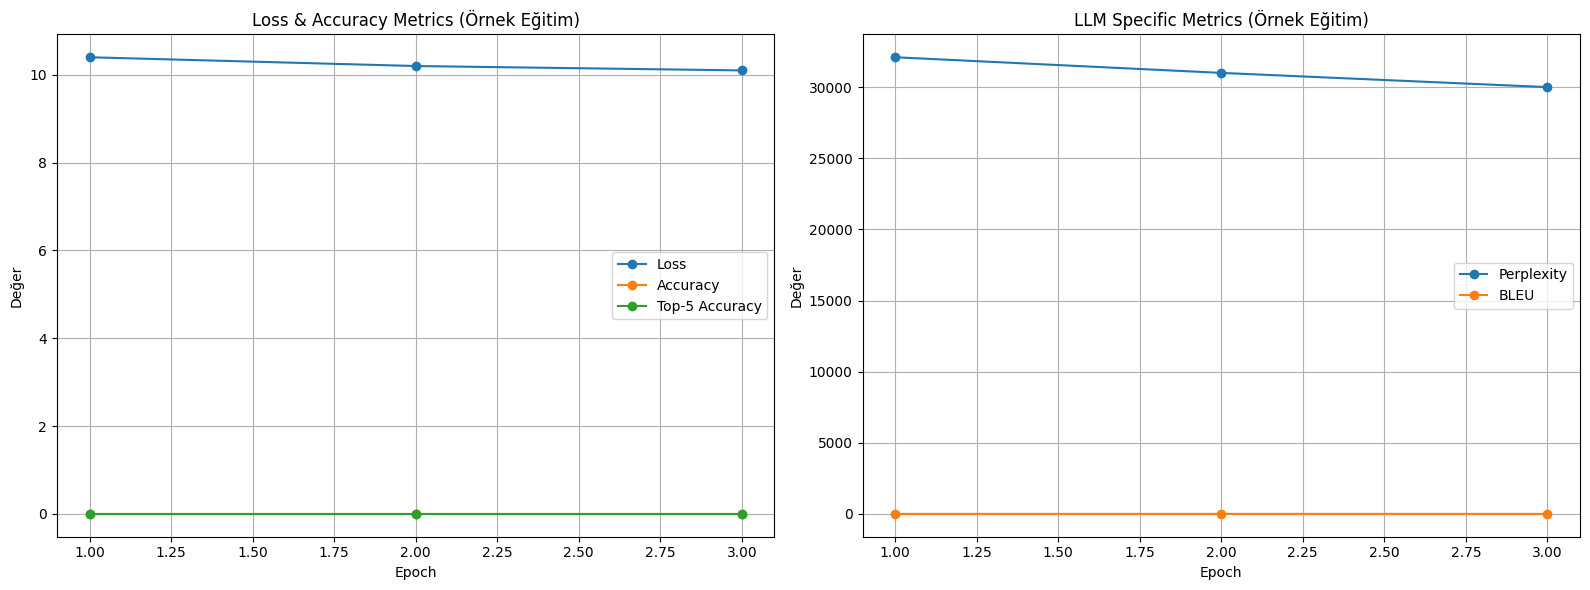

In [31]:
# Örnek dummy veriler
losses = [10.4, 10.2, 10.1]
accuracies = [0.0, 0.0, 0.0]
top5 = [0.0, 0.0, 0.0]
ppls = [32100, 31000, 30000]
bleus = [0.0, 0.05, 0.08]

plot_training_metrics(
    losses=losses,
    accuracies=accuracies,
    top5_accuracies=top5,
    perplexities=ppls,
    bleus=bleus,
    title_suffix="(Örnek Eğitim)"
)
